<a href="https://colab.research.google.com/github/Nichlas0403/DL_LSTM_Avocado-Prices/blob/main/LSTM_Avocado_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Recap of this notebook

**Goal**<br>
This notebook attemps to create a recurrent neural network using long short-term memory layers to predict the price of avocados.

**Data**<br>
The data has been provided by kaggle: <br> https://www.kaggle.com/neuromusic/avocado-prices

**Features (taken from kaggle)**

Some relevant columns in the dataset:

* Date - The date of the observation<br>
* AveragePrice - the average price of a single avocado<br>
* type - conventional or organic<br>
* year - the year<br>
* Region - the city or region of the observation<br>
* Total Volume - Total number of avocados sold<br>
* 4046 - Total number of avocados with PLU 4046 sold<br>
* 4225 - Total number of avocados with PLU 4225 sold<br>
* 4770 - Total number of avocados with PLU 4770 sold<br>

#Preparation


In [128]:
#Import tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.keras
import joblib

In [129]:
#Import data

df = pd.read_csv("/content/drive/MyDrive/Data Science, Machine Learning/Colab Notebooks/Deep Learning Projects/Recurrent Neural Networks/LSTM - Avocado price/avocado.csv",
                  parse_dates=["Date"],
                  dayfirst=True) #covnert Date-column to datetime-datatype
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [130]:
#Remove second index-column
df = df.drop("Unnamed: 0", axis=1)
df.sort_values("Date")
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   AveragePrice  18249 non-null  float64       
 2   Total Volume  18249 non-null  float64       
 3   4046          18249 non-null  float64       
 4   4225          18249 non-null  float64       
 5   4770          18249 non-null  float64       
 6   Total Bags    18249 non-null  float64       
 7   Small Bags    18249 non-null  float64       
 8   Large Bags    18249 non-null  float64       
 9   XLarge Bags   18249 non-null  float64       
 10  type          18249 non-null  object        
 11  year          18249 non-null  int64         
 12  region        18249 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 1.8+ MB


In [34]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [35]:
print(f"Earliest date: ")
print(df["Date"].min())
print(f"Latest date: ")
print(df["Date"].max())

Earliest date: 
2015-01-04 00:00:00
Latest date: 
2018-03-25 00:00:00


#DEA

##Plot AveragePrice over Date

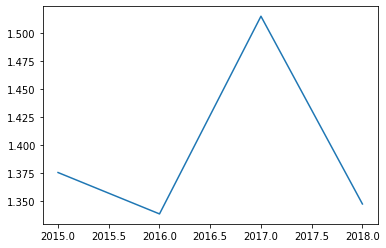

In [36]:
#Foreach year, get the average price
y = df.groupby(df["Date"].dt.year)['AveragePrice'].transform('mean').unique()

#Get unique years from df
x = df["Date"].dt.year.unique()

plt.plot(x,y);

##Plot volume over Date

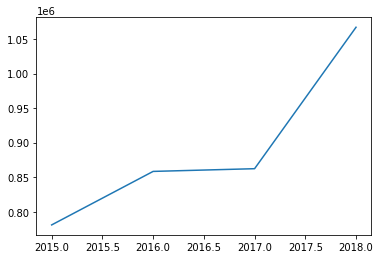

In [37]:
#Foreach year, get the average price
y = df.groupby(df["Date"].dt.year)['Total Volume'].transform('mean').unique()

#Get unique years from df
x = df["Date"].dt.year.unique()

plt.plot(x,y);

##Type-column

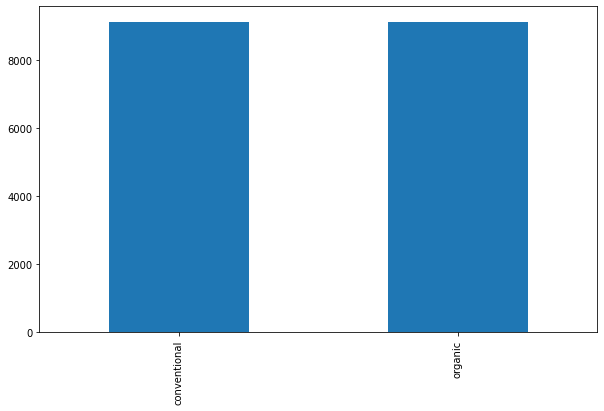

In [38]:
df["type"].value_counts().plot.bar(figsize=(10,6))

##Region-column

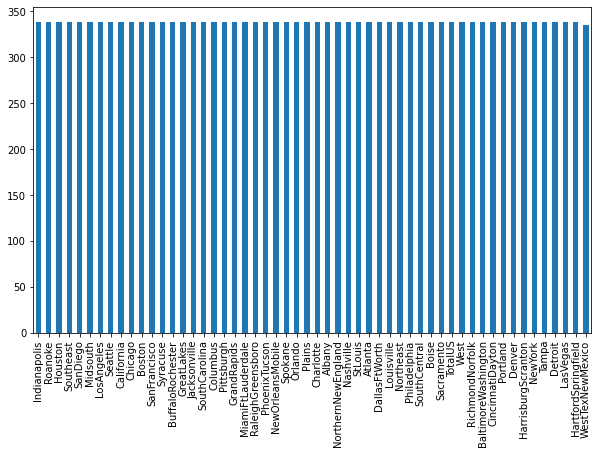

In [39]:
df["region"].value_counts().plot.bar(figsize=(10,6))

#Data preparation

What will be done in this section:

1. Transfer last 15% of the data to a validation dataframe
2. Convert type-column to numerical values
3. Convert region-column to numerical values
4. Remove year-column since we already have a datetime column
5. Normalize X 
6. Split data into X and y with a timestep of 60

##Seperate target from features

Before training the RNN, the data will be normalized. To make inverse transformation easier later, I will create a scaler both for the target and for the features. Since the data still exists in a dataframe, seperating the data now is the easiest.

In [132]:
target = df["AveragePrice"]
df = df.drop("AveragePrice",axis=1)

##Convert type-column

Since type only contains two different values, I will label encode this column.

In [133]:
df["type"].unique()

array(['conventional', 'organic'], dtype=object)

In [134]:
df["type"][0]

'conventional'

In [135]:
df["type"][9999]

'organic'

In [136]:
from sklearn.preprocessing import LabelEncoder

In [137]:
type_encoder = LabelEncoder()
df["type"] = type_encoder.fit_transform(df["type"])
joblib.dump(type_encoder, "/content/drive/MyDrive/Data Science, Machine Learning/Colab Notebooks/Deep Learning Projects/Recurrent Neural Networks/LSTM - Avocado price/scalers/type_encoder", compress=True)

['/content/drive/MyDrive/Data Science, Machine Learning/Colab Notebooks/Deep Learning Projects/Recurrent Neural Networks/LSTM - Avocado price/scalers/type_encoder']

In [138]:
#was "conventional" before
df["type"][0]

0

In [139]:
#was "organic" before
df["type"][9999]

1

##Convert date into numerical value

Since we don't have a time-of-day value on the date, I will convert the Date-values using toordinal()

**Note** <br>
The dataset has already been sortd by the date.

In [140]:
df["Date"] = df["Date"].apply(lambda x: x.toordinal())

In [141]:
df["Date"][0]

735959

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  int64  
 1   Total Volume  18249 non-null  float64
 2   4046          18249 non-null  float64
 3   4225          18249 non-null  float64
 4   4770          18249 non-null  float64
 5   Total Bags    18249 non-null  float64
 6   Small Bags    18249 non-null  float64
 7   Large Bags    18249 non-null  float64
 8   XLarge Bags   18249 non-null  float64
 9   type          18249 non-null  int64  
 10  year          18249 non-null  int64  
 11  region        18249 non-null  object 
dtypes: float64(8), int64(3), object(1)
memory usage: 1.7+ MB


##Remove year-column

In [143]:
df = df.drop("year",axis=1)
df.head()

,Date,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region
0,735959,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,0,Albany
1,735952,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,0,Albany
2,735945,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,0,Albany
3,735938,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,0,Albany
4,735931,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,0,Albany


##Convert region-column

The region-columns holds 54 different values. Since they are all well-represented in the dataset, I will do a onehot encoding which means I will convert this one column into 54 new columns. If some of these values wasn't well represented in the dataset, I would most likely have mapped those values to a "other"-value, as they wouldn't hold much statistical power anyways.

In [144]:
df["region"].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [145]:
len(df["region"].unique())

54

In [146]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [147]:
#convert region-values to categorical
df["region"] = df["region"].astype("category")

In [148]:
#convert df into numpy array
df_array = np.array(df)
df_array[0]

array([735959, 64236.62, 1036.74, 54454.85, 48.16, 8696.87, 8603.62,
       93.25, 0.0, 0, 'Albany'], dtype=object)

In [149]:
region_transformer = ColumnTransformer(transformers=[("encoder",OneHotEncoder(sparse=False), [10])], remainder="passthrough")
df_array = region_transformer.fit_transform(df_array)
joblib.dump(region_transformer, "/content/drive/MyDrive/Data Science, Machine Learning/Colab Notebooks/Deep Learning Projects/Recurrent Neural Networks/LSTM - Avocado price/scalers/region_transformer", compress=True)

['/content/drive/MyDrive/Data Science, Machine Learning/Colab Notebooks/Deep Learning Projects/Recurrent Neural Networks/LSTM - Avocado price/scalers/region_transformer']

In [150]:
df_array[0]

array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 735959, 64236.62, 1036.74, 54454.85, 48.16, 8696.87,
       8603.62, 93.25, 0.0, 0], dtype=object)

##Normalize data

Two scalers MinMaxScalers will be created:
1. One for the target column - this will make inverse transformation easier.
2. One for the rest of the features.

In [151]:
from sklearn.preprocessing import MinMaxScaler

In [152]:
feature_scaler = MinMaxScaler(feature_range=(-1,1))
target_scaler = MinMaxScaler(feature_range=(-1,1))

In [153]:
df_array = feature_scaler.fit_transform(df_array)
joblib.dump(feature_scaler, "/content/drive/MyDrive/Data Science, Machine Learning/Colab Notebooks/Deep Learning Projects/Recurrent Neural Networks/LSTM - Avocado price/scalers/feature_min_max_scaler", compress=True)

['/content/drive/MyDrive/Data Science, Machine Learning/Colab Notebooks/Deep Learning Projects/Recurrent Neural Networks/LSTM - Avocado price/scalers/feature_min_max_scaler']

In [154]:
df_array[0]

array([ 1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -0.39285714,
       -0.99794732, -0.99990883, -0.99467969, -0.99996217, -0.99910217,
       -0.9987144 , -0.99996739, -1.        , -1.        ])

In [155]:
target = np.array(target)
target = target_scaler.fit_transform(target.reshape(-1,1))
joblib.dump(target_scaler, "/content/drive/MyDrive/Data Science, Machine Learning/Colab Notebooks/Deep Learning Projects/Recurrent Neural Networks/LSTM - Avocado price/scalers/target_min_max_scaler", compress=True)

['/content/drive/MyDrive/Data Science, Machine Learning/Colab Notebooks/Deep Learning Projects/Recurrent Neural Networks/LSTM - Avocado price/scalers/target_min_max_scaler']

In [156]:
target[0], target.shape

(array([-0.36654804]), (18249, 1))

###Add target data to training set

In [157]:
df_array[0], target[0]

(array([ 1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -0.39285714,
        -0.99794732, -0.99990883, -0.99467969, -0.99996217, -0.99910217,
        -0.9987144 , -0.99996739, -1.        , -1.        ]),
 array([-0.36654804]))

In [158]:
df_array.shape, target.shape

((18249, 64), (18249, 1))

In [159]:
temp = pd.DataFrame(df_array)
temp[64] = target[:,0]
training_set_scaled = np.array(temp)

#Split training data into X and y with timestep = 60

X will hold alle the samples in a vektor. Each of these samples is a vektor of the 60 elements. Each of these elements holds the feature regarding that specific element.

Because of this struktur, X_train wil have a shape of (15452, 60, 65) and y_train will have a shape of (15452,).

If we have a sample from X: X_train[1,59,55], then the corrosponding y-value will be y[0].

In [160]:
X = []
y = []

for i in range(60, len(training_set_scaled)):
  X.append(training_set_scaled[i-60:i,:])
  y.append(training_set_scaled[i,55])


In [161]:
X = np.array(X_train)
y = np.array(y_train)

In [162]:
X[1,59,55]

-0.9865930593418827

In [163]:
y[0]

-0.9865930593418827

In [164]:
X.shape

(15452, 60, 65)

In [165]:
y.shape

(15452,)

In [166]:
from sklearn.model_selection import train_test_split

In [167]:
#Create test and validation set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [168]:
validation = (X_test, y_test)

#Modelling

##Create, compile and train the RNN

In [171]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [172]:
rnn = Sequential([
                  LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],65)), #X_train.shape[1] = 60. The 60 previous samples, 
                                                                                            #65 for 65 features
                                                                                            #This makes the shape: (60,65)
                  Dropout(0.4),
                  LSTM(units=50, return_sequences=True),                                                                          
                  Dropout(0.4),
                  LSTM(units=50, return_sequences=True),
                  Dropout(0.4),
                  LSTM(units=50, return_sequences=True),
                  Dropout(0.4),
                  LSTM(units=50),
                  Dropout(0.4),
                  Dense(units=1)
])

In [173]:
rnn.compile(optimizer="adam", loss="mean_squared_error",metrics=["mean_absolute_error"])

In [174]:
rnn.fit(X_train, y_train, validation_data=validation, epochs=10, batch_size=32)

Epoch 1/10
387/387 [==============================] - 76s 175ms/step - loss: 0.0616 - mean_absolute_error: 0.1668 - val_loss: 0.0113 - val_mean_absolute_error: 0.0672
Epoch 2/10
387/387 [==============================] - 69s 177ms/step - loss: 0.0190 - mean_absolute_error: 0.1015 - val_loss: 0.0054 - val_mean_absolute_error: 0.0357
Epoch 3/10
387/387 [==============================] - 68s 177ms/step - loss: 0.0148 - mean_absolute_error: 0.0890 - val_loss: 0.0041 - val_mean_absolute_error: 0.0251
Epoch 4/10
387/387 [==============================] - 67s 174ms/step - loss: 0.0108 - mean_absolute_error: 0.0771 - val_loss: 0.0040 - val_mean_absolute_error: 0.0205
Epoch 5/10
387/387 [==============================] - 67s 174ms/step - loss: 0.0098 - mean_absolute_error: 0.0718 - val_loss: 0.0030 - val_mean_absolute_error: 0.0203
Epoch 6/10
387/387 [==============================] - 68s 176ms/step - loss: 0.0077 - mean_absolute_error: 0.0620 - val_loss: 0.0027 - val_mean_absolute_error: 0.019

In [175]:
rnn.save("/content/drive/MyDrive/Data Science, Machine Learning/Colab Notebooks/Deep Learning Projects/Recurrent Neural Networks/LSTM - Avocado price/models/baseline_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data Science, Machine Learning/Colab Notebooks/Deep Learning Projects/Recurrent Neural Networks/LSTM - Avocado price/models/baseline_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data Science, Machine Learning/Colab Notebooks/Deep Learning Projects/Recurrent Neural Networks/LSTM - Avocado price/models/baseline_model/assets
